# FIT5202 Assignment 1 - Part A

## Step 01: Import pyspark and initialise Spark

In [1]:
# Importing necessary documents and libraries and creating entry points to spark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import math

conf = SparkConf().setMaster("local[*]")\
                  .setAppName("FIT5202 Assignment 1 - Part A")

sc = SparkContext.getOrCreate(conf=conf)

if sc == None:
    sc = SparkContext(conf=conf)

spark = SparkSession(sparkContext=sc)

## Step 02: Create Resilient Distributed Datasets (RDDs)

In [2]:
# Reading the two text file and making them into RDDs of strings
a_raw = sc.textFile("Agile Processes  in Software Engineering  and Extreme Programming.txt")
s_raw = sc.textFile("Scrum Handbook.txt")

print("The first book has {0} lines.".format(a_raw.count()))
print("The second book has {0} lines.".format(s_raw.count()))

The first book has 21569 lines.
The second book has 4617 lines.


## Step 03: Cleaning/Manipulating text

In [3]:
# A function to clean up the strings
def cleaning(string):
    string = string.lower()
    string = re.sub("[^a-z\s]", "", string)
    string = string.strip()
    return string

cleaned_a = a_raw.map(cleaning)\
              .filter(lambda x: len(x) != 0)
cleaned_s = s_raw.map(cleaning)\
              .filter(lambda x: len(x) != 0)

print(cleaned_a.take(20))
print(cleaned_s.take(20))

['lnbip', 'i helen sharp', 'tracy hall eds', 'agile processes', 'in software engineering', 'and extreme programming', 'th international conference xp', 'edinburgh uk may', 'proceedings', 'springer open', 'lecture notes', 'in business information processing', 'series editors', 'wil van der aalst', 'eindhoven technical university eindhoven the netherlands', 'john mylopoulos', 'university of trento povo italy', 'michael rosemann', 'queensland university of technology brisbane qld australia', 'michael j shaw']
['jeff sutherlands', 'scrum handbook', 'everything', 'you need', 'to know', 'to start', 'a scrum project', 'in your', 'organization', 'scrum', 'training', 'institute', 'm w press', 'this book is dedicated to nobel laureate muhammad yunus and the', 'grameen bank for originating microenterprise development and the', 'accion international presidents advisory board responsible for much of', 'microenterprise development in the western hemisphere', 'the strategy for bootstrapping the poor 

## Step 04 : Transforming the data/Counting the words

In [4]:
wordcount_a = cleaned_a.flatMap(lambda x: x.split())\
                       .map(lambda x: (x, 1))\
                       .reduceByKey(lambda x, y: x+y)\
                       .sortBy(lambda x: x[1], ascending = False)
print("There are {0} unique words in the first book.".format(wordcount_a.count()))
print(wordcount_a.take(20))

wordcount_s = cleaned_s.flatMap(lambda x: x.split())\
                       .map(lambda x: (x, 1))\
                       .reduceByKey(lambda x, y: x+y)\
                       .sortBy(lambda x: x[1], ascending = False)
print("There are {0} unique words in the second book.".format(wordcount_s.count()))
print(wordcount_s.take(20))

There are 9740 unique words in the first book.
[('the', 8145), ('and', 3965), ('of', 3944), ('to', 3714), ('in', 3076), ('a', 2701), ('is', 1539), ('that', 1355), ('for', 1194), ('as', 1028), ('on', 1015), ('we', 975), ('with', 969), ('software', 922), ('this', 915), ('are', 784), ('agile', 748), ('it', 741), ('development', 737), ('was', 711)]
There are 3056 unique words in the second book.
[('the', 1238), ('of', 537), ('and', 534), ('to', 477), ('a', 451), ('scrum', 395), ('in', 360), ('is', 348), ('team', 260), ('product', 232), ('for', 195), ('that', 181), ('it', 165), ('on', 149), ('sprint', 146), ('this', 142), ('with', 132), ('as', 124), ('are', 119), ('by', 118)]


## Step 05: Removing stop words

In [5]:
stopwords = set(nltk.corpus.stopwords.words('english'))

no_stopwords_a = wordcount_a.filter(lambda x: x[0] not in stopwords)\
                            .sortBy(lambda x: x[1], ascending = False)
no_stopwords_s = wordcount_s.filter(lambda x: x[0] not in stopwords)\
                            .sortBy(lambda x: x[1], ascending = False)

print("After the removal of stop words:")
print("There are {0} unique words in the first book.".format(no_stopwords_a.count()))
print("There are {0} unique words in the second book.".format(no_stopwords_s.count()))

After the removal of stop words:
There are 9611 unique words in the first book.
There are 2936 unique words in the second book.


## Step 06: Find the average occurence of a word

In [6]:
total_words_a = sum(no_stopwords_a.map(lambda x: x[1]).collect())
avg_occurrence_a = total_words_a/no_stopwords_a.count()

total_words_s = sum(no_stopwords_s.map(lambda x: x[1]).collect())
avg_occurrence_s = total_words_s/no_stopwords_s.count()

print("The average occurence of a word of the first book is {0}".format(avg_occurrence_a))
print("The average occurence of a word of the second book is {0}".format(avg_occurrence_s))

The average occurence of a word of the first book is 8.225574862137135
The average occurence of a word of the second book is 3.681880108991826


In [7]:
print(total_words_a)
print(total_words_s)

79056
10810


## Step 07: Exploratory data analysis

### Compare the distribution of words in Book1 and Book2. The data spans many orders of magnitude and the features of the distribution not quite evident in the linear space. Therefore, use log scale (base 10) to plot the graph. Explain your understanding based on the graphs.

For the both books, we can presume that most of the words' times of apperance may be concentrated at a particular range. Hence, we furtherly plot out the histogram of appearance of words.

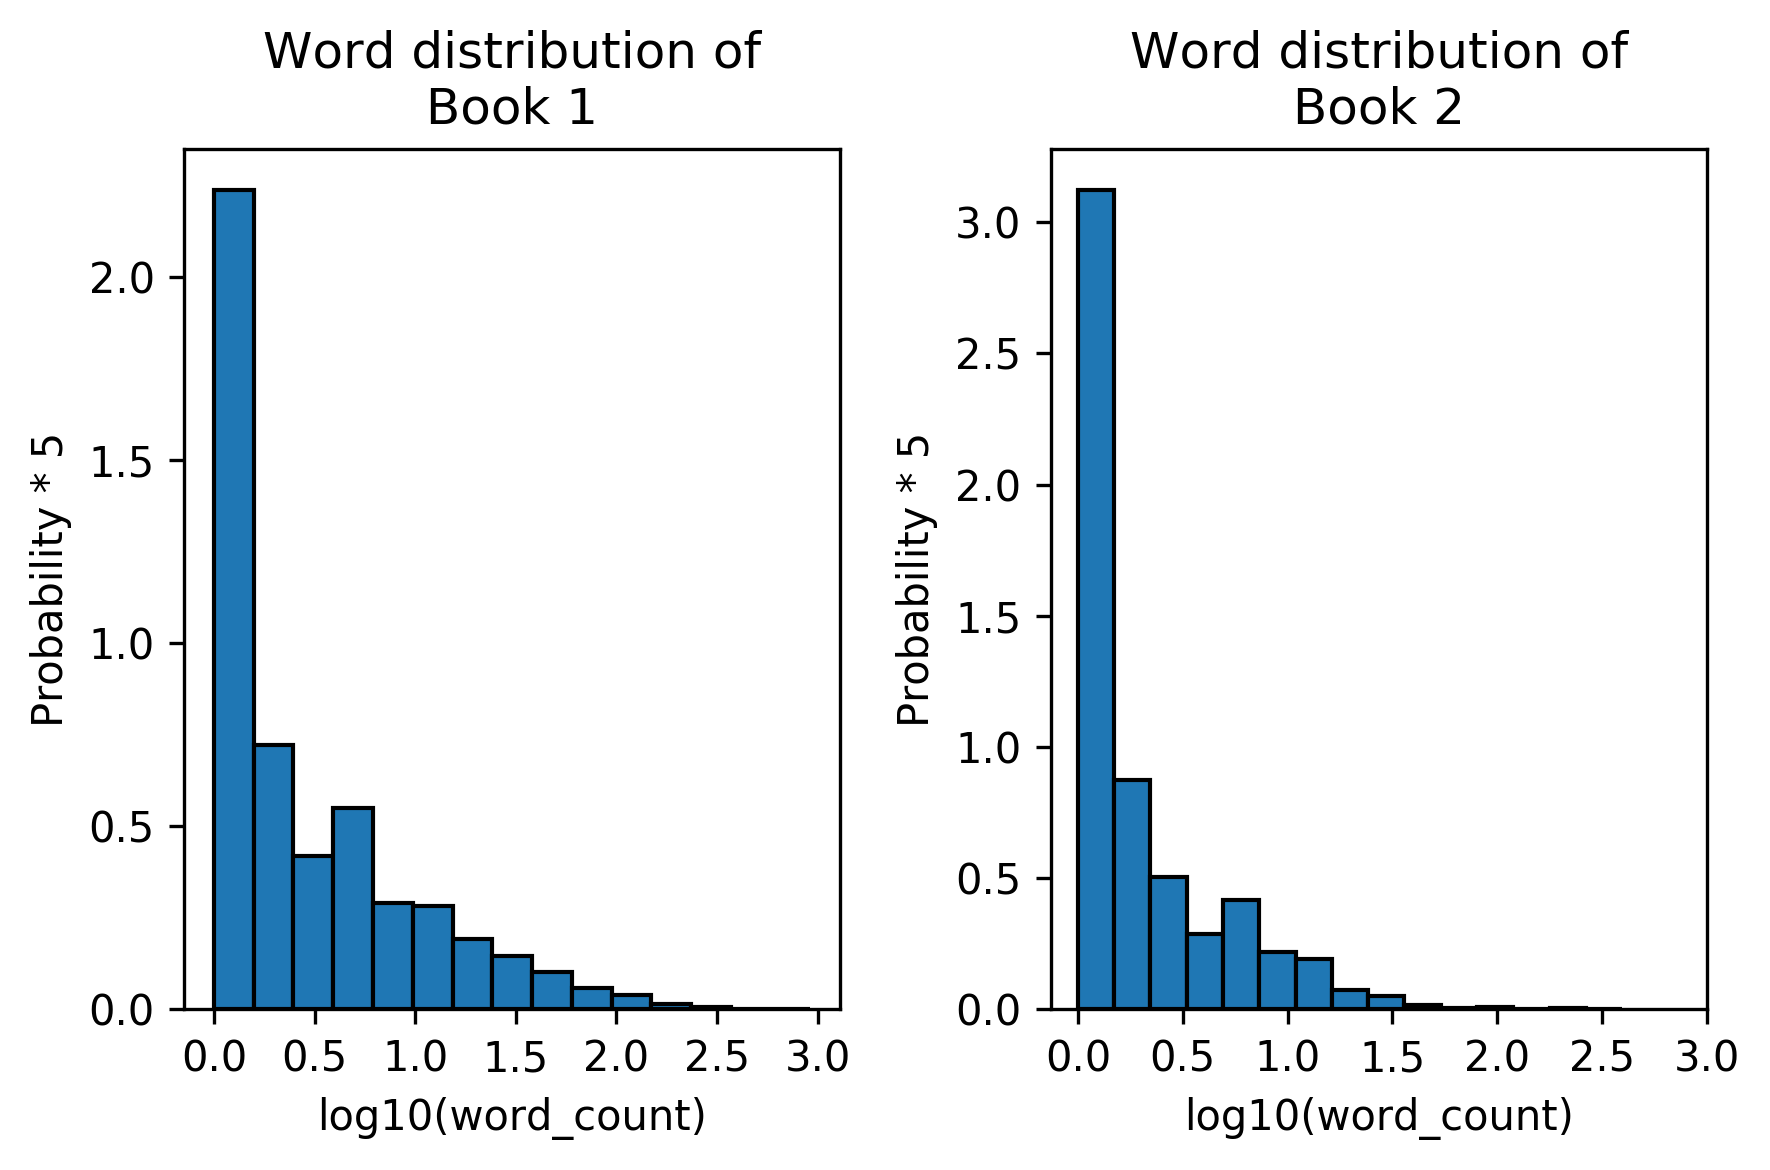

In [8]:
b1_x = no_stopwords_a.map(lambda x: x[1]).collect()
b1_y = no_stopwords_a.mapValues(math.log10).map(lambda x: x[1]).collect()
b2_x = no_stopwords_s.map(lambda x: x[1]).collect()
b2_y = no_stopwords_s.mapValues(math.log10).map(lambda x: x[1]).collect()

fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, dpi=300)
axs[0].hist(b1_y, bins=15, edgecolor="black", align="mid", density=True)
axs[1].hist(b2_y, bins=15, edgecolor="black", align="mid", density=True)

xticks = np.arange(0, 3.5, 0.5)
yticks = np.arange(0, 0.7, 0.05)
axs[0].set_xticks(xticks)
axs[1].set_xticks(xticks)
axs[0].set_title("Word distribution of\nBook 1")
axs[1].set_title("Word distribution of\nBook 2")
axs[0].set_xlabel("log10(word_count)")
axs[1].set_xlabel("log10(word_count)")
axs[0].set_ylabel("Probability * 5")
axs[1].set_ylabel("Probability * 5")

plt.show()
plt.close()

As we can tell from the two diagrams, most of the words in both books appear only once; they take up around half of the words of the books. The distributions of the words are right-skewed. As the appearance of the words increases, the probability decreases. The percentage of word that appear once is higher in book 1 than in book 2, which means book 1 has higher level of word diversity.

NB. This is a normalised histogram, where the sum of the area of bars is 1. Since the width of bars is 0.2, y-axis in this graph shall be the probability multiplied by 5.

### Compare the top 15 most common words in Book1 and Book2. Plot the graphs and explain your understanding of the graph.

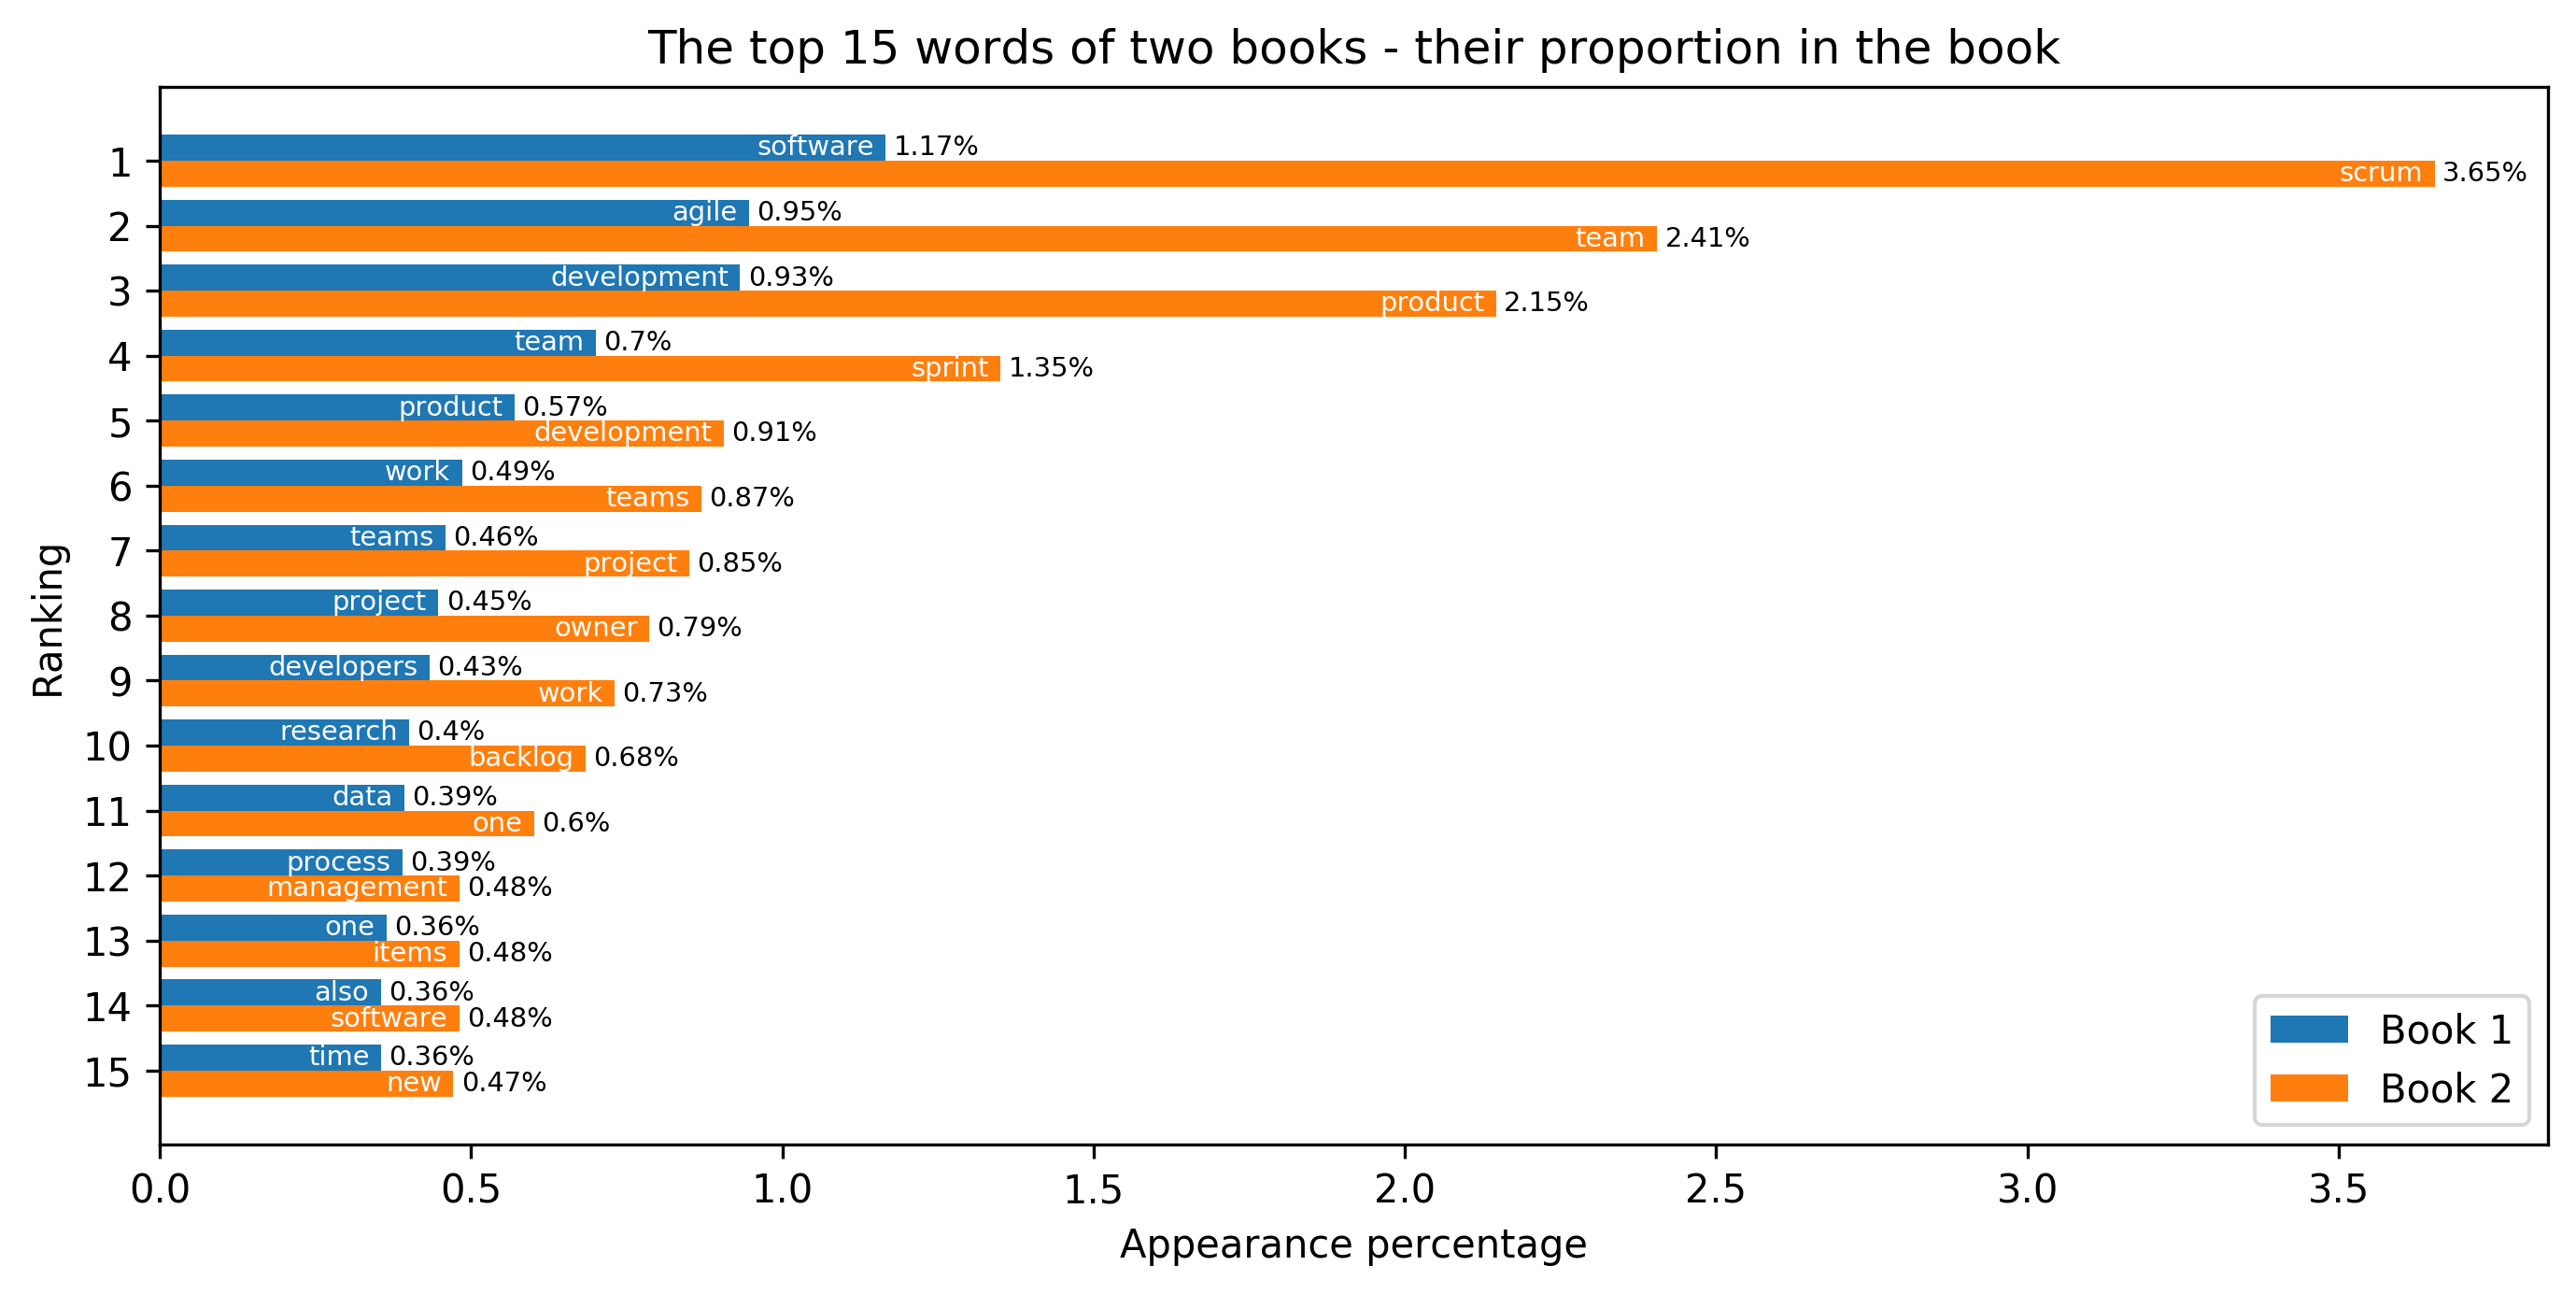

In [9]:
# All the source code are from the official example of matplotlib
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
# All parameters are adjusted by myself

labels = list(range(15, 0, -1))
total_1 = sum(no_stopwords_a.map(lambda x: x[1]).collect())
total_2 = sum(no_stopwords_s.map(lambda x: x[1]).collect())

b1_top15_rates = no_stopwords_a.map(lambda x: x[1]/total_1*100).take(15)
b2_top15_rates = no_stopwords_s.map(lambda x: x[1]/total_2*100).take(15)
b1_top15_words = no_stopwords_a.map(lambda x: x[0]).take(15)
b2_top15_words = no_stopwords_s.map(lambda x: x[0]).take(15)

postlabel_b1 = no_stopwords_a.map(lambda x: str(round(x[1]/total_1*100, 2)) + "%").take(15)
postlabel_b2 = no_stopwords_s.map(lambda x: str(round(x[1]/total_2*100, 2)) + "%").take(15)

fig, ax = plt.subplots(dpi=300)
rects1 = ax.barh(list(map(lambda x: x+0.2, list(range(15,0,-1)))),\
                 width=b1_top15_rates,\
                 height=0.4,\
                 label='Book 1')
rects2 = ax.barh(list(map(lambda x: x-0.2, list(range(15,0,-1)))),
                 width=b2_top15_rates,\
                 height=0.4,\
                 label='Book 2')

ax.set_title('The top 15 words of two books - their proportion in the book')
ax.set_yticks(labels)
ax.set_yticklabels(labels[::-1])
ax.legend()

ax.set_xlabel("Appearance percentage")
ax.set_ylabel("Ranking")

def autolabel(rects, prelabel, postlabel):
    i = 0
    for rect in rects:
        width = rect.get_width()
        ax.annotate(prelabel[i],\
                    xy=(rect.get_width(), rect.get_y()+0.5*rect.get_height()),\
                    xytext=(-3, 0),\
                    textcoords="offset points",\
                    ha='right', va='center',\
                    fontsize="x-small",\
                    color="white")
        ax.annotate(postlabel[i],\
                    xy=(rect.get_width(), rect.get_y()+0.5*rect.get_height()),\
                    xytext=(2, 0),\
                    textcoords="offset points",\
                    ha='left', va='center',\
                    fontsize="x-small",\
                    color="black")
        i += 1

autolabel(rects1, b1_top15_words, postlabel_b1)
autolabel(rects2, b2_top15_words, postlabel_b2)
fig.set_size_inches(11,5)
plt.show()

The top 3 words of the first book are "software", "agile", and "development"; and the top 3 words of the second book are "scrum", "team", and "product".
Since the total words of the two books are different, we decided to illustrate the top words' proportions instead of absolute quantity.
"scurm" as the most frequently-appeared word took 3.65% of the second book, whereas "software" only took 1.17% of total words. This proves our conclusion above: book 1 has higher level of word diversity.

---
This is the end of Part A.